In [3]:
# imports

import os
import re
import math
from tqdm import tqdm
from dotenv import load_dotenv
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, set_seed
from peft import LoraConfig, PeftModel
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
import matplotlib.pyplot as plt

In [4]:
# Tokenizers

LLAMA_3_1 = "meta-llama/Meta-Llama-3.1-8B"
QWEN_2_5 = "Qwen/Qwen2.5-7B"
GEMMA_2 = "google/gemma-2-9b"
PHI_3 = "microsoft/Phi-3-medium-4k-instruct"

# Constants

BASE_MODEL = LLAMA_3_1
HF_USER = "AJ14314"
DATASET_NAME = f"{HF_USER}/pricer-data"
MAX_SEQUENCE_LENGTH = 182 # 179 + 3
QUANT_4_BIT = True

# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

%matplotlib inline

In [5]:
# environment

load_dotenv(override=True)
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [6]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [7]:
def investigate_tokenizer(model_name):
    print("Investigating tokenizer for ", model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    for number in [0, 2, 10, 100, 999, 1000]:
        tokens = tokenizer.encode(str(number), add_special_tokens=False)
        print(f"The tokens for {number}: {tokens}")

In [8]:
# Now we will try this with each model: LLAMA_3_1, QWEN_2_5, GEMMA_2, PHI_3

print("Llama 3.1: ")
investigate_tokenizer(LLAMA_3_1)
print("\nQwen: ")
investigate_tokenizer(QWEN_2_5)
print("\nGemma: ")
investigate_tokenizer(GEMMA_2)
print("\nPhi: ")
investigate_tokenizer(PHI_3)

Llama 3.1: 
Investigating tokenizer for  meta-llama/Meta-Llama-3.1-8B
The tokens for 0: [15]
The tokens for 2: [17]
The tokens for 10: [605]
The tokens for 100: [1041]
The tokens for 999: [5500]
The tokens for 1000: [1041, 15]

Qwen: 
Investigating tokenizer for  Qwen/Qwen2.5-7B


tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

c:\Users\anand\.conda\envs\llm_learnings\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\anand\.cache\huggingface\hub\models--Qwen--Qwen2.5-7B. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

The tokens for 0: [15]
The tokens for 2: [17]
The tokens for 10: [16, 15]
The tokens for 100: [16, 15, 15]
The tokens for 999: [24, 24, 24]
The tokens for 1000: [16, 15, 15, 15]

Gemma: 
Investigating tokenizer for  google/gemma-2-9b


tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

c:\Users\anand\.conda\envs\llm_learnings\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\anand\.cache\huggingface\hub\models--google--gemma-2-9b. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

The tokens for 0: [235276]
The tokens for 2: [235284]
The tokens for 10: [235274, 235276]
The tokens for 100: [235274, 235276, 235276]
The tokens for 999: [235315, 235315, 235315]
The tokens for 1000: [235274, 235276, 235276, 235276]

Phi: 
Investigating tokenizer for  microsoft/Phi-3-medium-4k-instruct


tokenizer_config.json:   0%|          | 0.00/3.15k [00:00<?, ?B/s]

c:\Users\anand\.conda\envs\llm_learnings\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\anand\.cache\huggingface\hub\models--microsoft--Phi-3-medium-4k-instruct. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

The tokens for 0: [29871, 29900]
The tokens for 2: [29871, 29906]
The tokens for 10: [29871, 29896, 29900]
The tokens for 100: [29871, 29896, 29900, 29900]
The tokens for 999: [29871, 29929, 29929, 29929]
The tokens for 1000: [29871, 29896, 29900, 29900, 29900]


# Load our data

We uploaded it to Hugging Face, so it's easy to retrieve it now

In [9]:
dataset  = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

README.md:   0%|          | 0.00/416 [00:00<?, ?B/s]

c:\Users\anand\.conda\envs\llm_learnings\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\anand\.cache\huggingface\hub\datasets--AJ14314--pricer-data. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00001.parquet:   0%|          | 0.00/184M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/911k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [10]:
train[0]

{'text': 'How much does this cost to the nearest dollar?\n\nDelphi FG0166 Fuel Pump Module\nDelphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7\n\nPrice is $227.00',
 'price': 226.95}

In [11]:
test[0]

{'text': "How much does this cost to the nearest dollar?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K\n\nPrice is $",
 'price': 374.41}

# Prepare our Base Llama Model for evaluation

Load our base model with 4 bit quantization and try out 1 example

In [12]:
## Pick the right qunatization

if QUANT_4_BIT:
    quant_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_type="nf4"
    )
else:
    quant_config  = BitsAndBytesConfig(
        load_in_8bit = True,
        bnb_8bit_compute_dtype=torch.bfloat16
    )

In [14]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",  # Remove device_map="auto" since BitsAndBytesConfig handles it
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e9:.1f} GB")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Memory footprint: 5.6 GB


In [15]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','').replace('$','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [16]:
extract_price("Price is $999 blah blah so cheap")

999.0

In [17]:
def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = base_model.generate(inputs, max_new_tokens=4, attention_mask=attention_mask, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [18]:
model_predict(test[0]['text'])

1800.0

# Evaluation!

Trying out our base Llama 3.1 model against the Test dataset

In [19]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

In [21]:
# Plot fix

plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({
    'figure.figsize': (15, 6),
    'font.size': 10,
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Arial', 'Helvetica'],
})
%matplotlib inline

1: Guess: $1,800.00 Truth: $374.41 Error: $1,425.59 SLE: 2.46 Item: OEM AC Compressor w/...
2: Guess: $25.00 Truth: $225.11 Error: $200.11 SLE: 4.68 Item: Motorcraft YB3125 Fa...
3: Guess: $25.00 Truth: $61.68 Error: $36.68 SLE: 0.77 Item: Dorman Front Washer ...
4: Guess: $1,999.00 Truth: $599.99 Error: $1,399.01 SLE: 1.45 Item: HP Premium HD Plus T...
5: Guess: $7.50 Truth: $16.99 Error: $9.49 SLE: 0.56 Item: Super Switch Pickup ...
6: Guess: $1.00 Truth: $31.99 Error: $30.99 SLE: 7.86 Item: Horror Bookmarks, Re...
7: Guess: $89.99 Truth: $101.79 Error: $11.80 SLE: 0.01 Item: SK6241 - Stinger 4 G...
8: Guess: $299.00 Truth: $289.00 Error: $10.00 SLE: 0.00 Item: Godox ML60Bi LED Lig...
9: Guess: $299.00 Truth: $635.86 Error: $336.86 SLE: 0.57 Item: Randall G3 Plus Comb...
10: Guess: $25.99 Truth: $65.99 Error: $40.00 SLE: 0.83 Item: HOLDWILL 6 Pack LED ...
11: Guess: $110.00 Truth: $254.21 Error: $144.21 SLE: 0.69 Item: Viking Horns 3 Gallo...
12: Guess: $1,800.00 Truth: $412.99 Error

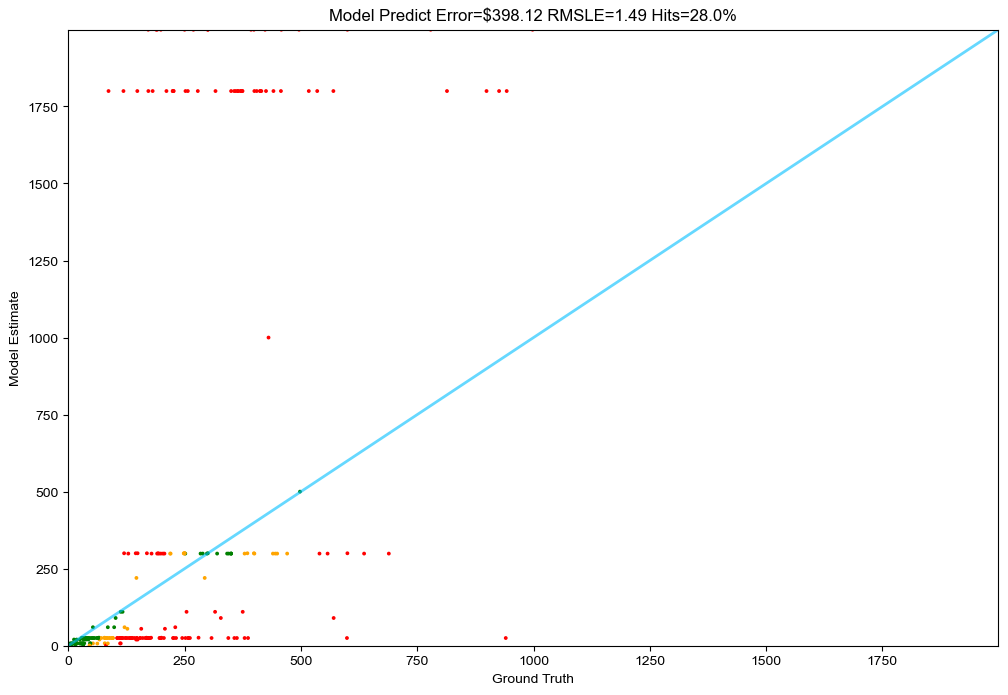

In [22]:
Tester.test(model_predict, test)